# **CSE 344 - Computer Vision : Assignment 1**
**Name :** Arka Sarkar  <br>
**Roll Number :** 2018222 <br>

Importing the dependencies

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
from collections import deque
import copy
from itertools import product
import cv2
import random as rng
import math

### Question 1 
Find tightest bounding circles for the objects present in the given image.[3 Marks] <br>
**Expected O/Ps**: centers & radiuses of those circles, and a visualization showing both the objects and the circles in a single image. <br>
[0.25] marks for the center. <br> 
[0.15] andthe radius. <br> 
[0.1] for any object. <br>
[0.75] marks for the is ualization. <br>

Loading the RBG **Project1.png** image to work upon of shape (639,960,3)

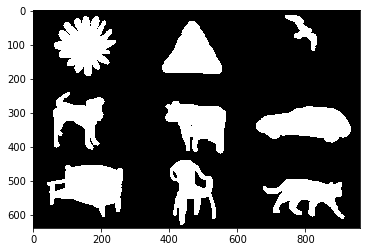

(639, 960, 3)


In [2]:
image = cv2.imread("Project1.png")
plt.imshow(image)
plt.show()
print(image.shape)

### **Connected Components**

The first part of drawing the bounding circles, is to detect the total number of connected components(objects). <br>

**Algorithm :**
* Convert the RBG image into a grayscale image.
* Apply otsu on the grayscale image and segment it into a binary image, where 1 is foreground and 0 is background.
* A counter that maintains the number of connected components found.
* Iterate through the rows and columns of the binary image and for every not visited pixel in the image mark it visited and interate through all the connected neighbours that are marked as 1 and not visited, and increment the counter. 
* Save the pixels for each connected component separately and return it along with the max number that the counter achieved. 

In [3]:
def get_components(image):
    gray_img = np.mean(image,2)
    val = filters.threshold_otsu(gray_img)
    gray_img[gray_img >= val] = 1
    gray_img[gray_img < val] = 0
    
    rows, cols = gray_img.shape[0], gray_img.shape[1]
    visited = np.zeros((rows,cols))

    answer = np.zeros((rows,cols))
    centers = {}
    c = 1
    for i in range(rows):
        for j in range(cols):

            if(gray_img[i][j] == 0.0):
                visited[i,j] = 1
            elif(visited[i,j]):
                continue
            else:
                stack = deque()
                stack.append((i,j))
                
                centers[c] = []
                
                while(len(stack)!=0):
                    curr = stack.pop()
                    if(visited[curr[0],curr[1]] == 0):
                        visited[curr[0],curr[1]] = 1
                        m,n = curr[0],curr[1]
                        answer[m,n] = c
                        list_ = []
                        for x in range(m-1, m+2):
                            for y in range(n-1, n+2):
                                if(x == m and y == n):
                                    continue
                                else:
                                    if(x <0 or x > rows -1):
                                        continue
                                    if(y <0 or y > cols -1):
                                        continue

                                    if(gray_img[x,y] == 1.0):
                                        centers[c].append((x,y))
                                        stack.append((x,y))
                c = c + 1


    return np.amax(answer), centers


### **Draw Bounding Circles**
The next part of is to compute the radius and the center of all the connected components, from the pixels of each component recieved from the above function. <br>

For each connected component :
  $$ height = max(y_i) -  min(y_i)$$ <br>
  $$ width = max(x_i) -  min(x_i)$$ <br>
  $$ Center(x,y) = \frac{min(x_i) + max(x_i)}{2} ,\frac{min(y_i) + max(y_i)}{2} $$ <br>
  $$ Radius = max(\sqrt{(x_i - Center_x)^2 + (y_i - Center_y)^2}) $$
  where $(x_i,y_i)$ is the $i^{th}$ pixel coordinates of the current connected component.

In [32]:
def get_bounding_circles(image):
    
    n, centers = get_components(image)
    
    centers_radius = {}
    for key in list(centers.keys()):
        arr = np.array(centers[key])
        height = np.max(arr[:,1]) - np.min(arr[:,1])
        width = np.max(arr[:,0]) - np.min(arr[:,0])
        x0,y0 = np.min(arr[:,1]), np.min(arr[:,0])
        x1,y1 = np.max(arr[:,1]), np.max(arr[:,0])
#         center_y, center_x = np.mean(arr,0) 
        center_x,center_y = int((x0+x1)/2), int((y0+y1)/2)
#         radius = int(((height**2 + width**2)**0.5)/2)
#         radius = max(math.ceil(height/2), math.ceil(width/2))
        radius = 0
        for i in range(arr.shape[0]):
            radius = max(radius, ((arr[i][0] - center_y)**2 + (arr[i][1] - center_x)**2)**0.5)
            
        centers_radius[key] = {"center_coordinates" : (int(center_x), int(center_y)), "radius": int(radius)}
        print("centre coordinates for object ",str(key),": ", "(", int(center_x), int(center_y), ")", "radius : ",int(radius) )
    
    curr_image = copy.deepcopy(image)
    for key in list(centers_radius.keys()):
         
        color = (255, 0, 0)
        thickness = 2
        curr_image = cv2.circle(curr_image, centers_radius[key]["center_coordinates"], centers_radius[key]["radius"], color, thickness)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        fontScale = 1
        curr_image = cv2.putText(curr_image, str(key), centers_radius[key]["center_coordinates"], font, fontScale, color, thickness, cv2.LINE_AA) 
    
    cv2.imwrite("bounding_image.jpg", curr_image)
    fig = plt.figure(figsize = (10,10))
    plt.imshow(curr_image)
    plt.show()
    
    return centers_radius

centre coordinates for object  1 :  ( 787 67 ) radius :  68
centre coordinates for object  2 :  ( 153 105 ) radius :  94
centre coordinates for object  3 :  ( 466 109 ) radius :  112
centre coordinates for object  4 :  ( 133 324 ) radius :  104
centre coordinates for object  5 :  ( 477 343 ) radius :  108
centre coordinates for object  6 :  ( 793 335 ) radius :  141
centre coordinates for object  7 :  ( 468 534 ) radius :  102
centre coordinates for object  8 :  ( 152 529 ) radius :  127
centre coordinates for object  9 :  ( 794 553 ) radius :  131


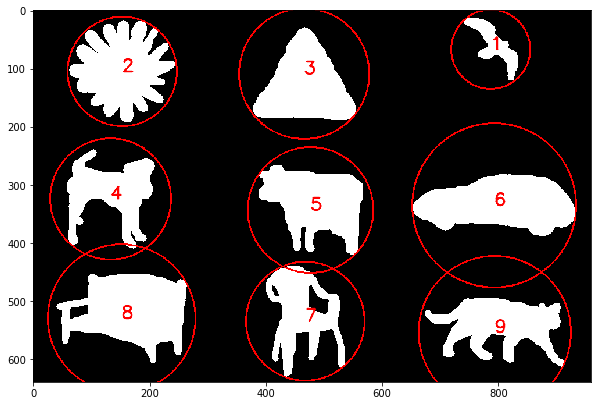

In [33]:
center_radius = get_bounding_circles(image)

### Question 2
Find Jaccard Similarity scores for each of the objects in the image given with respect to their corresponding circular regions obtained in Q1.[2 Marks] <br>
[0.65] marks for implementing the Jaccard Similarity module that takes two binary masks as inputs and outputs the required score. <br>
[0.15] marks for Jaccard Similarity score for any object. 

### Jaccard Similarity
Jaccard Similarity computes the intersection of two binary marks BM1 and BM2 divided by the union of BW1 and BW2. <br>
<br>
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
where $A,B$ are the two binary masks.

In [34]:
def jaccard_similarity(binary_mask1, binary_mask2):
    intersection = len(list(set(binary_mask1).intersection(set(binary_mask2))))
    union = len(set(binary_mask1).union(set(binary_mask2)))
    return float(intersection) / union
    

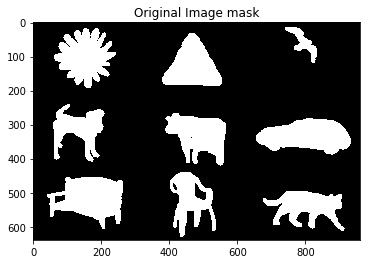

In [35]:
gray_img = np.mean(image,2)
val = filters.threshold_otsu(gray_img)
gray_img[gray_img >= val] = 1
gray_img[gray_img < val] = 0
plt.imshow(gray_img, cmap = 'gray')
plt.title("Original Image mask")
plt.show()

In [36]:
def points_in_circle_np(radius, x0=0, y0=0, ):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    list_ = []
    for x, y in zip(x_[x], y_[y]):
        list_.append((x,y))
    return list_

In [37]:
def get_jaccard_similarity(image):
    n, centers = get_components(image)
    centers_radius = {}
    for key in list(centers.keys()):
        arr = np.array(centers[key])
        center_x, center_y = np.mean(arr,0)
        radius = max((np.max(arr[:,0]) - np.min(arr[:,0]))/2, (np.max(arr[:,1]) - np.min(arr[:,1]))/2)
        centers_radius[key] = {"center_coordinates" : (int(center_y), int(center_x)), "radius": int(radius)}
        
    circle_coordinates = {}
    for key in list(center_radius.keys()):
        radius = center_radius[key]["radius"]
        y,x = center_radius[key]["center_coordinates"]
        circle_coordinates[key] = points_in_circle_np(radius,x,y)
        IOU = jaccard_similarity(centers[key], circle_coordinates[key])
        print("The IOU (jaccard similarity) score for object ", str(key) ,"  is : ", IOU)
    return circle_coordinates, centers
                

The IOU (jaccard similarity) score for object  1   is :  0.23626714453098077
The IOU (jaccard similarity) score for object  2   is :  0.6958387422472234
The IOU (jaccard similarity) score for object  3   is :  0.4259672996851833
The IOU (jaccard similarity) score for object  4   is :  0.3818149686312627
The IOU (jaccard similarity) score for object  5   is :  0.4727059337300071
The IOU (jaccard similarity) score for object  6   is :  0.32706538104238075
The IOU (jaccard similarity) score for object  7   is :  0.3973319462717621
The IOU (jaccard similarity) score for object  8   is :  0.4197716227428978
The IOU (jaccard similarity) score for object  9   is :  0.2818971275885104


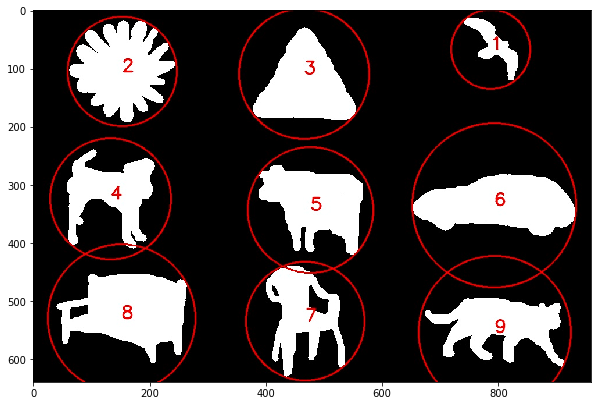

In [38]:
circle_coordinates,centers = get_jaccard_similarity(image)
bounding_image = cv2.imread("bounding_image.jpg")
plt.figure(figsize = (10,10))
plt.imshow(bounding_image)
plt.show()